### Install Modules

In [ ]:
# ! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
! echo "Installing Deps"
! pip install -r requirements.txt
! echo "Installed Deps"
! pip freeze > requirements.txt

### Importing Modules

In [ ]:
import nltk
import json
import torch
import numpy as np
import random
import torch.nn as nn # neural net
from nltk.stem.porter import PorterStemmer
from torch.utils.data import Dataset, DataLoader

### Download Pre-Trained Tokenizer from NLTK

In [ ]:
nltk.download('punkt')

### Initialise Stemmer 

In [ ]:
stemmer = PorterStemmer()

### NLTK Utilities

In [ ]:
def tokenize(sentence: str) -> list[str]:
    return nltk.word_tokenize(sentence)


def stem(word: str) -> ...:
    return stemmer.stem(word.lower())


def bag_of_words(tokenized_sentence: list[str], all_words: list[str]) -> ...:
    """
    sentence = ["hello", "how", "are", "you"]
    words = ["hi", "hello", "I", "you", "bye", "thank", "cool"]
    bag   = [  0 ,    1,     0 ,   1  ,   0  ,    0   ,    0  ]

    """
    stemmed_tokenized_sentence = list(map(stem, tokenized_sentence))

    bag = np.zeros(len(all_words), dtype=np.float32)
    for i, word in enumerate(all_words):
        if word in stemmed_tokenized_sentence:
            bag[i] = 1.

    return bag

### Test Tokenizer

In [ ]:
test_string = "What are the working hours?"
tokenize(test_string)

### Test Stemmer

In [ ]:
words = ["organize", "ORGANIZES", "organizing", "Organization"]
list(map(stem, words))

### Test Bag Of Words

In [ ]:
sentence = ["hello","how", "are", "you"]
words = ["hi", "hello", "I", "you", "bye", "thank", "cool"]
print(bag_of_words(sentence, words))

## Pre Process Data

### Load Intents

In [ ]:

with open('intents.json', 'r') as f:
    intents = json.load(f)


### NLP Preprocessing
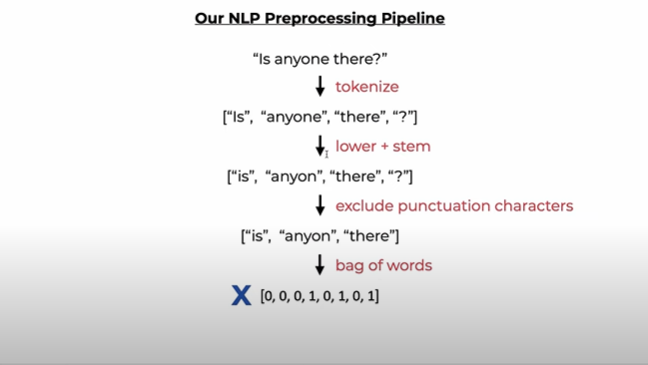

### Perform Stemming

In [ ]:
all_words, tags, xy = [], [], []
for intent in intents['intents']:
    tag = intent['tag']
    tags.append(tag)
    for pattern in intent['patterns']:
        words = tokenize(pattern)
        all_words.extend(words)
        xy.append((words, tag))

### Perform Stemming

In [ ]:
punctuations = "?", "!", ".", ","
stemmed_words = list(map(stem, filter(lambda word: word not in punctuations, all_words)))
stemmed_words = sorted(set(stemmed_words))
tags = sorted(set(tags))

### Perform Bag of Words

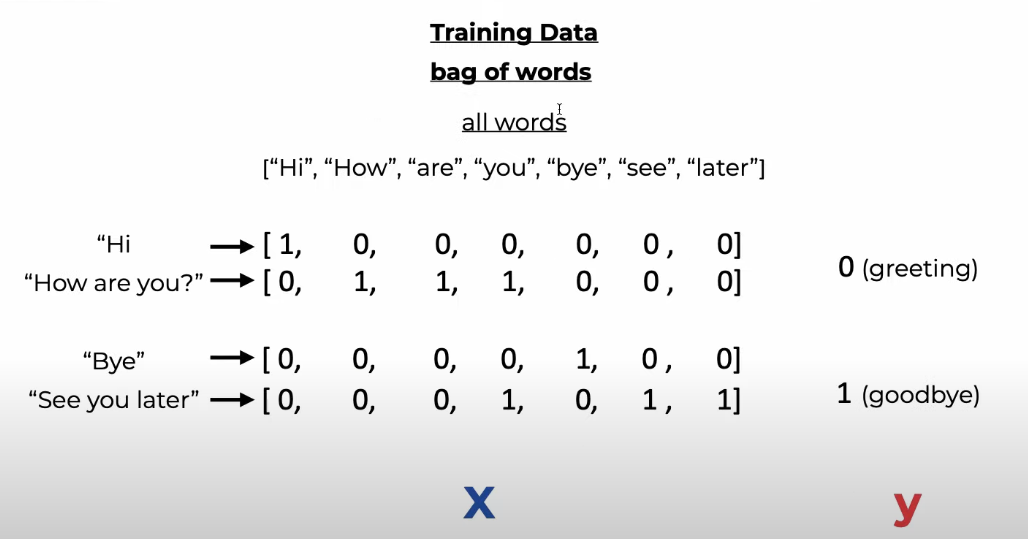

In [ ]:
X_train, Y_train = [], []

for pattern_sentence, tag in xy:
    bag = bag_of_words(pattern_sentence, all_words)
    X_train.append(bag)

    label = tags.index(tag)
    Y_train.append(label)

X_train = np.array(X_train)
Y_train = np.array(Y_train)

### Create Dataset

In [ ]:
class ChatDataset(Dataset): 
    def __init__(self):
        self.n_samples = len(X_train)
        self.x_data = X_train
        self.y_data = Y_train
    
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.n_samples



### Hyper Parameters

In [ ]:
num_epochs = 1000
batch_size = 8
learning_rate = .001
input_size = len(X_train[0])
hidden_size = 8
output_size = len(tags)

In [ ]:
dataset = ChatDataset()
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

### Deep Learning Model NLP

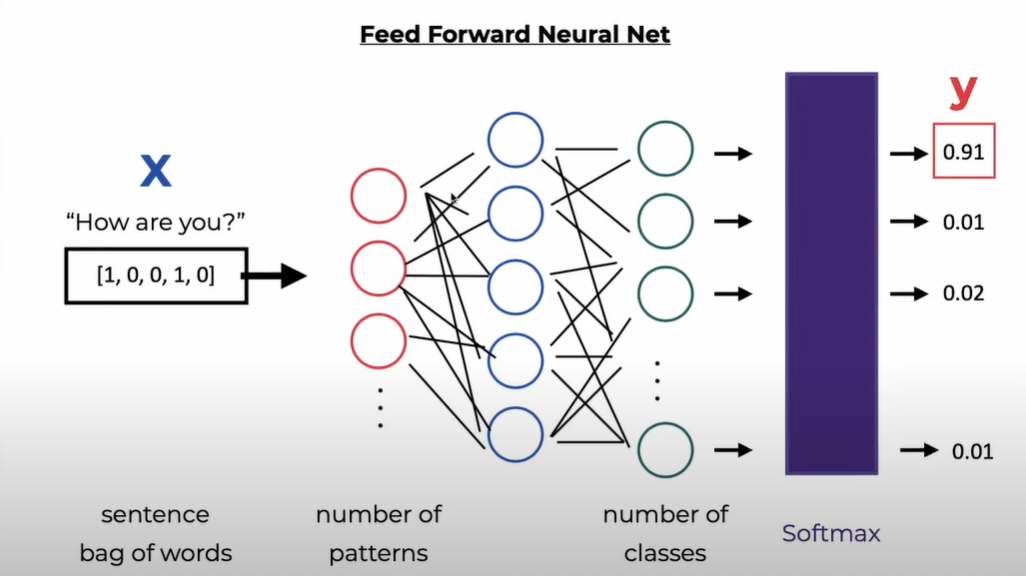

In [ ]:
class NeuralNet(nn.Module):
    def __init__(self, input_size:int, hidden_size:int, num_classes:int):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU() # Rectified Linear Unit
    
    def forward(self, x):
        output = self.l1(x)
        output = self.relu(output)
        output = self.l2(output)
        output = self.relu(output)
        return self.l3(output)


### Create a Device

In [ ]:
device = torch.device(['cpu', 'cuda'][torch.cuda.is_available()])
device

### Creating the Model

In [ ]:
model = NeuralNet(input_size, hidden_size, output_size).to(device)
model

### Loss and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Epochs

In [ ]:
for epoch in range(num_epochs):
    for words, labels in train_loader:
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)

        # forward
        outputs = model(words)
        loss = criterion(outputs, labels)

        # feedback: backward and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 100 == 0: 
        print(f'epoch {epoch+1}/{num_epochs}, loss={loss.item():.4f}') 


print(f'final loss, loss={loss.item():.4f}') 


#### Save Model state

In [ ]:
data = {
    "model_state": model.state_dict(),
    "input_size": input_size,
    "output_size": output_size,
    "hidden_size": hidden_size,
    "all_words": stemmed_words,
    "tags": tags
}

FILE = "data.pth"
torch.save(data, FILE)
f'training complete. file saved to {FILE}'

In [ ]:
model_state = data["model_state"]

### Chat with the model

In [ ]:
FILE = "data.pth"

data = torch.load(FILE)


model = NeuralNet(input_size, hidden_size, output_size).to(device)
model.load_state_dict(model_state)
model.eval()
model

In [ ]:
def generateResponse(query:str) -> str:
    X = bag_of_words(tokenize(query), all_words)
    X = X.reshape(1, X.shape[0])
    X = torch.from_numpy(X).to(device)

    output = model(X)
    _, predicted = torch.max(output, dim=1)
    tag = tags[predicted.item()]


    probs = torch.softmax(output, dim=1)
    prob = probs[0][predicted.item()]

    if prob.item() < .75:
        return "Please contact the HR Support"
     
    for intent in intents['intents']:
        if tag == intent['tag']:
            return random.choice(intent["responses"])
    
    return "Please contact the HR Support"

In [ ]:
generateResponse("office hours?")